# Phys 512: Homework 5

## 1. An adaptive Runge-Kutta integrator

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

def derivs_orbit(t, x):
    rr = (x[0]**2 + x[1]**2)**0.5
    vxdot = -x[0]/rr**3
    vydot = -x[1]/rr**3
    xdot = x[2]
    ydot = x[3]
    return np.array((xdot,ydot,vxdot,vydot))

# Function for the fourth-order Runge-Kutta integration method
def rk4(t, dt, x, derivs):    
    f = derivs(t, x)
    f1 = derivs(t + dt/2, x + f*dt/2)
    f2 = derivs(t + dt/2, x + f1*dt/2)
    f3 = derivs(t + dt, x + f2*dt)
    return x + dt*(f + 2*f1 + 2*f2 + f3)/6


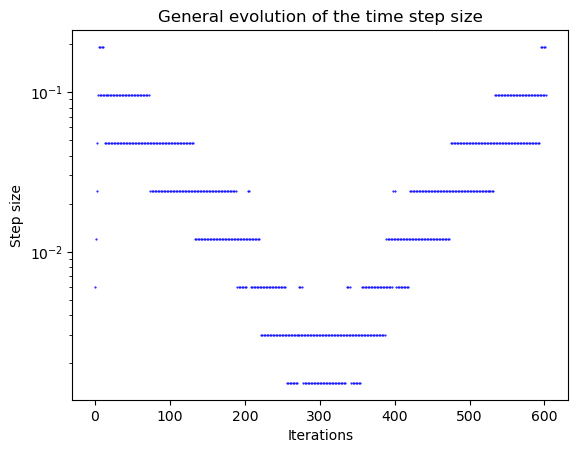

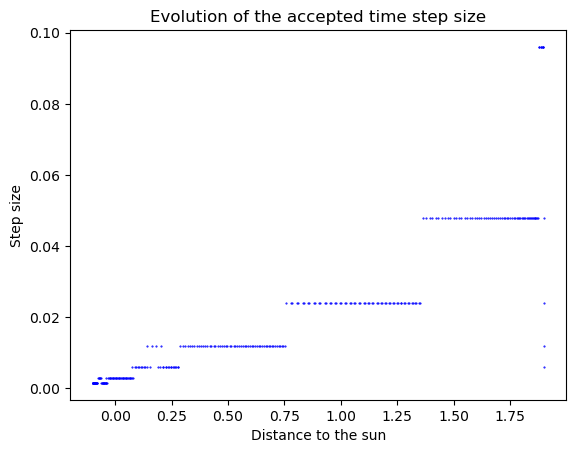

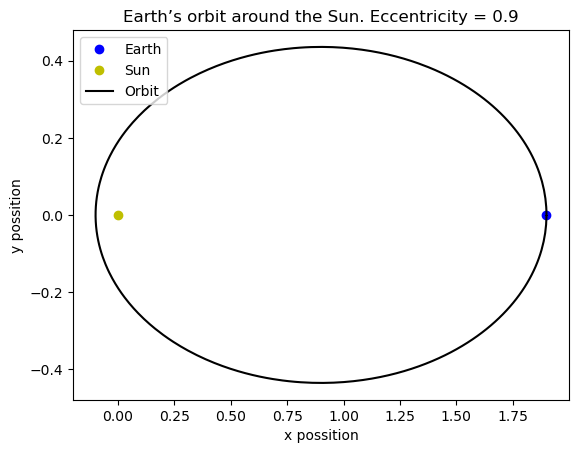

orbit time = 6.28319, nsteps = 303, err4 = 2.74889e-06


In [8]:
# Simulation parameters
N = 10000 # Initial number of time steps
dt = 0.006 # Initial guess for the time division
e = 0.9  # Eccentricity
x0 = np.array((1+e, 0, 0, np.sqrt(2/(1+e)-1)))  # Initial conditions

x = np.zeros((N,len(x0)))
x[0] = x0

size_steps = np.array([])
t = 0
steps = 0
accepted_steps = np.array([])
position_steps = np.array([])


while t < 2*np.pi:
    #Keep track of the step's size
    size_steps = np.append(size_steps, dt)
    # Perform a full time step and two half steps with error comparison
    x_full_step = rk4(t, dt, x[steps], derivs_orbit)
    x_first_half_step = rk4(t, dt/2, x[steps], derivs_orbit)
    x_second_half_step = rk4(t + dt/2, dt/2, x_first_half_step, derivs_orbit)
    
    error = abs(x_full_step - x_second_half_step)
    
    if error[0] < 10**(-9):
        t = t +  dt
        if t >= 2*np.pi:
            t = t-dt
            break
        steps = steps + 1
        x[steps] = x_full_step
        accepted_steps = np.append(accepted_steps, dt)
        dt = dt*2
    else:
        dt = dt/2

# Plot the evolution of step sizes
plt.plot(range(len(size_steps)), size_steps, 'b.', markersize=1 )
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Step size')
plt.title('General evolution of the time step size')
plt.show()

# Plot the accepted step sizes
plt.plot(x[:steps,0], accepted_steps,'b.', markersize=1 )
plt.xlabel('Distance to the sun')
plt.ylabel('Step size')
plt.title('Evolution of the accepted time step size')
plt.show()

# Compute the last step and plot the final orbit
dt_last = 2*np.pi - t
x[steps+1] = rk4(t, dt_last, x[steps], derivs_orbit)
t = t+ dt_last

plt.plot(x[0,0],x[0,1],'bo', label = 'Earth')
plt.plot(0,0,'yo', label = 'Sun')
plt.plot(x[:steps+1,0], x[:steps+1,1], 'k-', label = 'Orbit')
plt.xlabel('x possition')
plt.ylabel('y possition')
plt.legend(loc = 'upper left')
plt.title('Earth’s orbit around the Sun. Eccentricity = %lg' %(e))
plt.show()
print("orbit time = %lg, nsteps = %d, err4 = %lg" % (t, steps, x[steps+1,1]))



In the first plot, we can observe the evolution of the time step size over the total number of iterations. The initial and final iterations correspond to the points farthest from the sun, while the central values pertain to the closest distances, as shown in the second plot (we can see three small steps for further distances. Those correspond to the drift of the initial choosen steps to the optimized ones). This demonstrates how our algorithm selects smaller time steps for positions nearer to the sun and larger steps for locations farther away. Since an object on an eccentric orbit spends varying amounts of time in different parts of the orbit, we adapt the time step size to each segment where less time is spent.

As seen in the last plot, to return to the initial position with a precision of approximately $10^{-6}$, it took 303 steps in precisely $t=2\pi$ within almost 600 total iterations.


Now, let's compare the number of steps required to complete a full orbit with a precision of $10^{-6}$ using a constant time step.

In [9]:
def rk4_fullorbit(nsteps, dt, x0, derivs):
    x = np.zeros((nsteps,len(x0)))
    x[0] = x0
    for i in range(1,nsteps):    
        f = derivs((i-1)*dt, x[i-1])
        f1 = derivs((i-1)*dt + dt/2, x[i-1] + f*dt/2)
        f2 = derivs((i-1)*dt + dt/2, x[i-1] + f1*dt/2)
        f3 = derivs(i*dt, x[i-1] + f2*dt)
        x[i] = x[i-1] + dt*(f + 2*f1 + 2*f2 + f3)/6
    return x

nsteps = 4000

#define the constant timestep we will use to get a full orbit
dt_orbit = 2 * np.pi / (nsteps-1)
t_orbit = np.arange(nsteps)*dt_orbit
x_orbit = rk4_fullorbit(nsteps, dt_orbit, x0, derivs_orbit)

print("nsteps = %d, err = %lg" % (nsteps, x_orbit[-1,1]))


nsteps = 4000, err = 1.02832e-06


The difference is nearly an order of magnitude. Using variable time steps significantly improves memory efficiency. However, when considering both accepted and rejected steps, the time spent on the simulation isn't as significantly improved with the adaptive time step method, though it remains superior.

## 2. Method of lines

To solve the partial differential equation, we must consider the following boundary conditions:

$$T(x<1,t=0) = 1 \quad \text{,} \quad T(x = 1, t) = 0 \quad \text{and} \quad T(x = 0, t) = 1$$

If we aim to solve the equation for every possible time, we should start by applying separation of variables, assuming that the solution takes the form:

$$T(x,t) = \phi(x)\theta(t)$$

Substituting this into the partial differential equation, along with the boundary conditions, results in a function that only depends on time on one side and a function that only depends on space on the other side. We then introduce a separation constant, leading to two separate ordinary differential equations:

$$ \frac{\partial T(x,t)}{\partial t} = \frac{\partial^2 T(x,t)}{\partial x^2} \rightarrow \frac{1}{\theta(t)} \frac{\partial \theta(t)}{\partial t} = -\lambda = \frac{1}{\phi (x)} \frac{\partial^2 \phi(x)}{\partial x^2} $$

Solving these equations separately would allow us to find the general solution. However, our primary interest lies in the steady state, as we do not have complete knowledge of the time scale of the system (the steady state could be reached in milliseconds or hours). To determine the steady state, we set $\frac{\partial T}{\partial t} = 0$, resulting in $\frac{\partial^2 T}{\partial x^2} = 0$. For this equation, we know that a general solution is $T(x, t\rightarrow \infty) = Ax + B$. By imposing the boundary conditions:

$$T(0, t\rightarrow \infty) = B=1 \quad \text{,} \quad T(1, t\rightarrow \infty) = A+1 =0 \quad \rightarrow \quad A = -1$$

Therefore, after a long time, our temperature profile will be a straight line: $\boxed{T(x, t\rightarrow \infty) = -x+1 }$. This profile decreases from $T=1$ to $T=0$.



To obtain the temperature profile as a function of time and distance, we will employ the backward Euler method. This involves reformulating the derivative for the $L$ temperatures as a matrix multiplication between a positive-definite matrix $C$ and a vector containing all the temperatures. Assuming the length of the metal bar is $L$ and that we have divided it into a grid with $N$ divisions, the matrix $C$ will be of size $N\times N$. The derivative can be expressed as:

$$\frac{dT_i}{dt} = \frac{T_{i+1}-2T_i+T_{i-1}}{\Delta x ^2}$$

This leads to the following matrix-vector equation:

$$\vec{T}'= -C \vec{T} \rightarrow  
\begin{pmatrix}
T_0'\\
T_1'\\
T_2'\\
T_3'\\
\vdots\\
\end{pmatrix} =-\frac{1}{\Delta x^2} 
\begin{pmatrix}
0 & 0 & 0 & 0 & \ldots \\
-1 & 2 & -1 & 0 & \ldots \\
0 & -1 & 2 & -1 & \ldots \\
\vdots & \ddots & \ddots & \ddots & \ddots \\
\end{pmatrix} 
\begin{pmatrix}
T_0\\
T_1\\
T_2\\
T_3\\
\vdots\\
\end{pmatrix} $$

To construct the matrix $C$, we consider the boundary conditions: $\frac{dT_0}{dt} = \frac{dT_N}{dt} = 0$.

Now, to update the temperature distribution, we use the backward Euler formula:

$$T_i(t+\Delta t) = T_i(t) + \Delta t T_i'(t+\Delta t) \rightarrow \vec{T}(t+\Delta t) = \vec{T}_i(t) - C \Delta t \vec{T}(t+\Delta t) $$

By rearranging, we arrive at:

$$\vec{T}(t+\Delta t) = (I + C \Delta t )^{-1} \vec{T}(t)$$


We initialize the temperature distribution with a step-like distribution: $T_{i= [0,1]}(0) = 1$, while keeping the boundary points fixed (since we know their values): $T_{i = 0}(t) = 1$ and $T_{i = 1}(t) = 0$. This gives us a matrix where each column represents a grid point along the metal bar, and each row corresponds to a time step.


We continue updating the temperature vector over time until we reach a certain tolerance, which is computed as the difference between temperatures at the current time step and the previous one. This allows us to determine when the stationary state has been reached, making further simulation unnecessary.

Time to reach the steady state = 0.918 time units


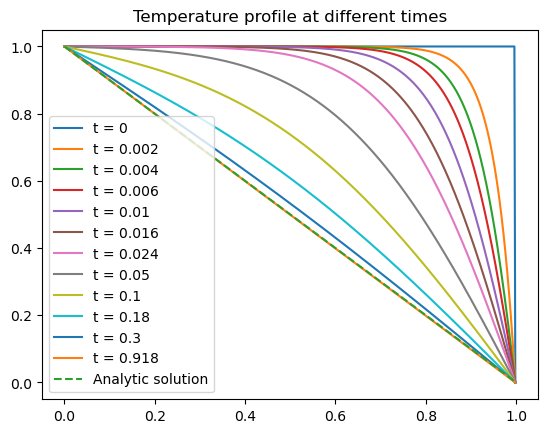

In [10]:
import numpy as np
import matplotlib.pyplot as plt


#Boudary conditions
T0 = 1
T1 = 0

#Simulation parameters
#Initially we will set the simulation time range to two seconds. 
#However, we will see that we are going to reach the steady state sooner
tf = 2  # Final time
L = 1   # Length of the metal bar
time = 1000  # Number of time steps
N = 500  # Number of spatial divisions

#Discretization parameters
dt = tf / time  # Time step
dx = L / N  # Spatial step

#Matrix for finite difference method
C = np.zeros((N,N))
derivative = np.array([-1,2,-1])

# Build the matrix
for i in range(N-2):
    row = np.zeros(i)
    row = np.append(row, derivative)
    row = np.append(row, np.zeros(N-3-i))
    C[i+1] = row

A = np.linalg.inv(np.identity(N) + dt*C/dx**2)

# Create the temperature array
T = np.zeros((time,N))

#put the boundary and initial conditions in the matrix
#x=0 condition, x=1 condition, and t=0 condition

# Set the boundary and initial conditions
T[:, 0] = T0  # x = 0 -> T = 1 
T[0, :] = T0  # initial condition
T[:, -1] = T1  # x = 1 -> T = 0 

#start the iteration over time
for i in range(1,time):
    T[i] = A@T[i-1]
    e = sum(abs(T[i]-T[i-1]))/N #measure of change between iterations
    if e<10**(-6): #tolerancy, if the change is less than 10**(-6) we consider that we have reach the steady state
        last_step = i
        print("Time to reach the steady state = %lg time units" %(i*dt))
        break

x = dx * np.arange(N)    
#Select time steps we will plot
plots = [0, 1, 2, 3, 5, 8, 12, 25, 50, 90, 150, last_step]

#plot temperature profiles at different times
for i in plots:
    plt.plot(x,T[i], label = 't = %lg' %(i*dt))

plt.plot(x,-x+1,"--", label = 'Analytic solution') #plot of the analytic solution (a straight line)
plt.legend(loc = 'lower left')
plt.title('Temperature profile at different times')
plt.show()


It's important to recall that the total time is calculated as $dt$ multiplied by the number of time steps, which means we reach the steady state just after simulating approximately $0.9$ seconds. Also, we have to realize how fast the initial changes are made compared to the time it takes to fully reach the steady state. Furthermore, it's worth noting that in the limit of an extended time period, the numerical solution approaches the exact theoretical solution, with both results nearly overlapping.


For a more intuitive representation of the temperature evolution over time, we can create a heat map using the matrix we generated. In this 2D map, the vertical axis corresponds to each time step, while the horizontal axis displays the actual temperature distribution along the metal bar.

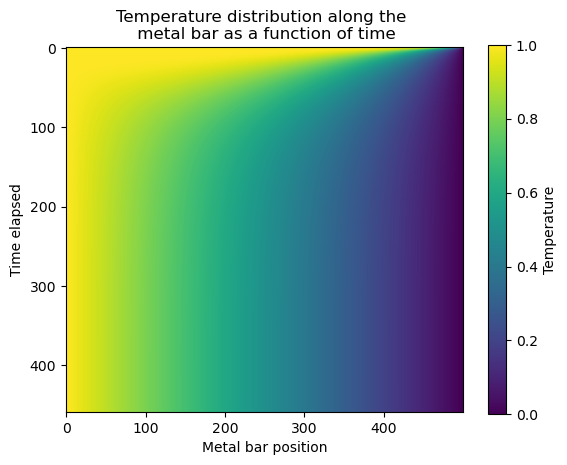

In [11]:

plt.imshow(T[:last_step])
plt.colorbar(label = 'Temperature')
plt.title('Temperature distribution along the \n metal bar as a function of time')
plt.xlabel('Metal bar position')
plt.ylabel('Time elapsed')
plt.show()


This visualization allows us to observe how, at the beginning, the entire metal piece has a temperature of T=1. However, it quickly begins to lose temperature, eventually reaching a perfect color gradient. This gradient signifies that we've attained the steady state, and the temperature now distributes linearly across the metal bar.